In [1]:
import ephem
import json
from shapely.geometry import shape, mapping, Point
import fiona
import gdal
import ogr, osr
import struct
import math
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pytz

%matplotlib inline

## DEM analysis

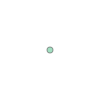

In [2]:
# Load site using shapely

with open ('inputs/site.geojson') as f:
    js = json.load(f)

s = shape(js['features'][0]['geometry'])
s

In [3]:
# Load digital elevation model

dem = gdal.Open('inputs/dem/filled.tif')

In [4]:
# Reproject the site to coords of dem for sampling elevation

site = ogr.Geometry(ogr.wkbPoint) # create an ogr geom instead of shapely
site.AddPoint(s.x, s.y)

sr = dem.GetProjection()
destSR = osr.SpatialReference()
inSRS_converter = osr.SpatialReference()
inSRS_converter.ImportFromWkt(sr)
inSRS_proj4 = inSRS_converter.ExportToProj4()
destSR.ImportFromProj4(inSRS_proj4)

srcSR = osr.SpatialReference()
srcSR.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
srTrans = osr.CoordinateTransformation(srcSR,destSR)

site_reproj = site
site.Transform(srTrans)
print(site_reproj.ExportToWkt())

POINT (-3010468.19566961 753062.757047171 0)


In [5]:
# Get site elevation

gt=dem.GetGeoTransform()
rb=dem.GetRasterBand(1)


def get_elev_at_point(geotransform, rasterband, pointgeom):
    mx,my=pointgeom.GetX(), pointgeom.GetY()
    #Convert from map to pixel coordinates.
    #Only works for geotransforms with no rotation.
    px = int((mx - geotransform[0]) / geotransform[1]) #x pixel
    py = int((my - geotransform[3]) / geotransform[5]) #y pixel
    intval=rasterband.ReadAsArray(px,py,1,1)[0]
    return intval[0]
    
site_elev = get_elev_at_point(gt, rb, site_reproj)
site_elev

1304.3667

Doing the viewshed analysis in QGIS using https://github.com/zoran-cuckovic/QGIS-visibility-analysis

Options:
- horizon search radius 20 km
- target (site) height 2 meters above surface
- adapting out 3 pixels (15 meters/~50 feet) from site to find high spot


Kept working in qgis for speed, will convert to this notebook eventually

In QGIS the horizon was:
- converted to ascii
- imported as points

Then:
- the dem was sampled with the horizon pts
- distance to site from each point calculated (m)
- inclination angle to each point calculated `degrees(atan((horizon_elev-site_elev)/distance)`

Bearing calculated using
```
degrees(atan(($x_at(0)-site_lon)/($y_at(0)-site_lat))) + (180 *((($y_at(0)-site_lat) < 0) + ((($x_at(0)-site_lon) < 0 AND ($y_at(0)-site_lat) >0)*2)))
```

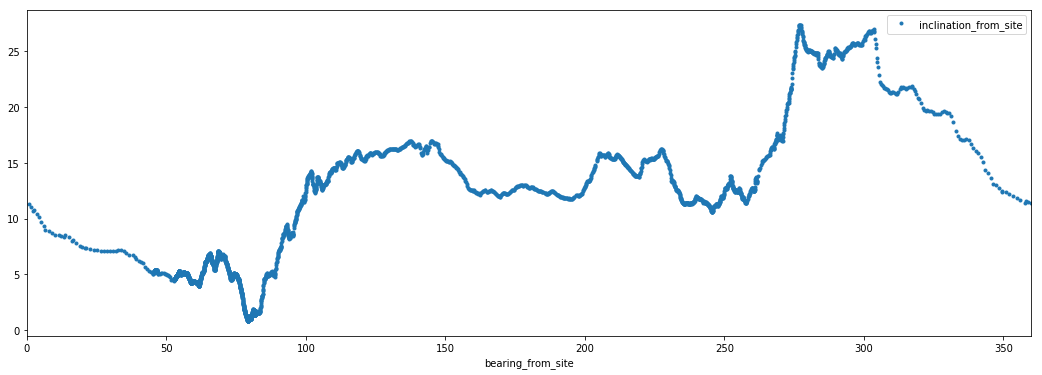

In [6]:
df = pd.read_csv('inputs/viewshed/horizon_dist.csv')
df.plot(x='bearing_from_site', y='inclination_from_site', style='.', figsize=(18,6), xlim=(0, 360))

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.loc[df['inclination_from_site'].idxmax()]

long                        -149.066
lat                           61.910
epsg3413_x              -3009867.500
epsg3413_y                754147.500
elevation                   1947.183
id                           738.000
meters_from_site            1239.961
inclination_from_site         27.403
bearing_from_site            277.162
Name: 737, dtype: float64

## Solar analysis

In [8]:
panel = ephem.Observer()
panel.lon = str(s.x) # this needs to be a string. derp
panel.lat = str(s.y)
panel.elevation = site_elev+2 # +2meters stays consistent with viewshed analysis
# panel.date = '2017/05/17 20:30:00' # utc time
panel

<ephem.Observer date='2017/5/25 02:19:19' epoch='2000/1/1 12:00:00' lon='-149:02:39.2' lat='61:54:25.8' elevation=1306.36669921875m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>

In [13]:
from pytz import all_timezones, common_timezones
local = pytz.timezone('America/Anchorage')

def get_sunangles(time_utc, observer):
    observer.date = time_utc
    solar = ephem.Sun(observer)
    a = {}
    a['az'] = math.degrees(solar.az)
    a['alt'] = math.degrees(solar.alt)
    return a

get_sunangles(datetime.datetime.utcnow(), panel)

df1 = pd.DataFrame(index=pd.date_range('2018-01-01 00:00', '2018-12-31 23:00', freq='H', tz=local))

df1['ts_utc'] = (df1.index).tz_convert(pytz.timezone('UTC'))
df1['az'] = df1.apply(lambda row: get_sunangles(row['ts_utc'], panel)['az'], axis=1)
df1['alt'] = df1.apply(lambda row: get_sunangles(row['ts_utc'], panel)['alt'], axis=1)


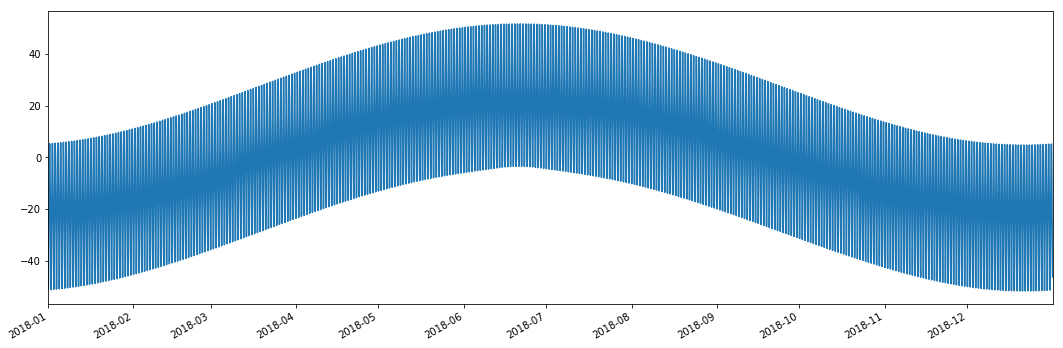

In [28]:
df1.alt.plot(figsize=(18,6))